In [1]:
import matplotlib.image as mpimg
import numpy as np
from matplotlib import pyplot as plt

# Read Image

In [2]:
"""
Reading the image
Input: image file name
Returning its pixels in list and its width and height
"""

def read_image(filename):
    image_in = mpimg.imread(filename) 
    width_in, height_in = image_in.shape
    return image_in, width_in, height_in

image_in, width_in, height_in = read_image("Cameraman.png")
#image_in, width_in, height_in = read_image("Lenna.jpg")

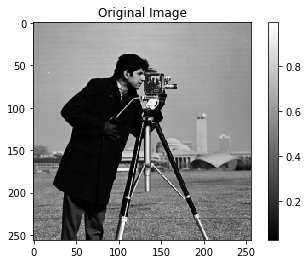

In [3]:
"""
Prints the image
Input: image pixels in list
"""

def print_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.colorbar()
    plt.show()

print_image(image_in, "Original Image")

# Sobel operator

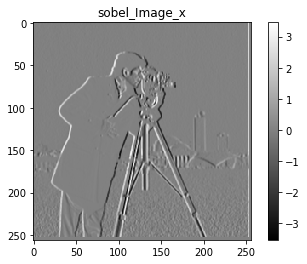

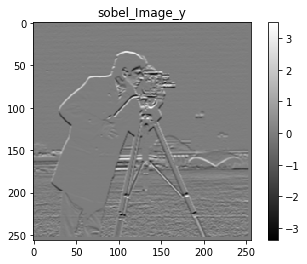

In [4]:
"""
Compute the intensity gradient in horizontal and vertical direction
Input: image pixels in list
Output: horizontal and vertical derivative of the input image
"""

def Sobel_Horizontal_Vertical(image):
    #Sobel Filter for x direction
    sx1 = np.array([1,2,1])[:,None] # column
    sx2 = np.array([1,0,-1])[None,:] # row

    #Sobel Filter for y direction
    sy1 = np.array([1,0,-1])[:,None] # column
    sy2 = np.array([1,2,1])[None,:] # row

    row, column = image.shape

    sobel_Image_x = np.zeros((row,column))
    sobel_Image_y = np.zeros((row,column))

    # Convolution using 1st Sobel filter
    for i in range(1, row-1):
        for j in range(1, column-1):
            hx = sx1[0][0] * image[i-1][j] + sx1[1][0] * image[i][j] + sx1[2][0] * image[i+1][j]
            hy = sy1[0][0] * image[i-1][j] + sy1[1][0] * image[i][j] + sy1[2][0] * image[i+1][j]

            sobel_Image_x[i-1][j-1] = hx
            sobel_Image_y[i-1][j-1] = hy

    # Convolution using 2nd Sobel filter
    for i in range(1, row-1):
        for j in range(1, column-1):
            hx = sx2[0][0] * sobel_Image_x[i][j-1] + sx2[0][1] * sobel_Image_x[i][j] + sx2[0][2] * sobel_Image_x[i][j+1]
            hy = sy2[0][0] * sobel_Image_y[i][j-1] + sy2[0][1] * sobel_Image_y[i][j] + sy2[0][2] * sobel_Image_y[i][j+1]

            sobel_Image_x[i-1][j-1] = hx
            sobel_Image_y[i-1][j-1] = hy
    
    return(sobel_Image_x, sobel_Image_y)

sobel_Image_x, sobel_Image_y = Sobel_Horizontal_Vertical(image_in)

print_image(sobel_Image_x, "sobel_Image_x")
print_image(sobel_Image_y, "sobel_Image_y")

# Gaussian smoothing

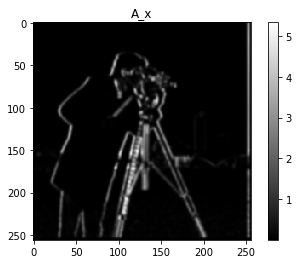

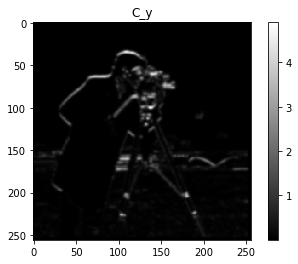

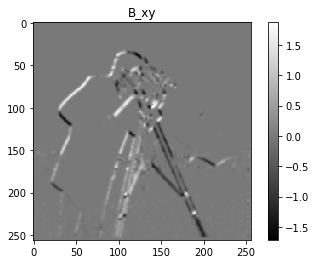

In [5]:
"""
Input kernal size
Returns gaussian_kernel, sum of all numbers in gaussian_kernel
http://www.subsurfwiki.org/wiki/Gaussian_filter
"""

def make_gaussian_kernel(size):
    x, y = np.mgrid[-size:size+1, -size:size+1] # returns a dense multi-dimensional “meshgrid”
    g = np.exp(-((x**2/float(size))+(y**2/float(size)))) # sigma = 1
    return g, g.sum()

kernel_size = 3
gaussian_kernel, S = make_gaussian_kernel(kernel_size)

"""
Fill the corners with 0's based on kernel_size
Input: image pixels in list, kernel_size
Returns the zero filled image pixels in list
"""

def zero_padding(image, kernel_size):
    width = image.shape[0]
    mat_zero = np.zeros(width)
    image_in_list = list(image)
    # making top and bottom rows zeros "kernel_size" times
    for i in range(kernel_size):
        image_in_list.insert(0, mat_zero)
        image_in_list.insert(len(image_in_list), mat_zero)
    # making right and left columns zeros "kernel_size" times
    for i in range(kernel_size):
        for k in range(len(image_in_list)):
            image_in_list[k] = list(image_in_list[k])
            image_in_list[k].insert(0, 0)
            image_in_list[k].insert(len(image_in_list[k]), 0)
    image_in_zero_pad = np.array(image_in_list)
    #width, height = image_in_zero_pad.shape
    return(image_in_zero_pad)

"""
Blurring the image using Gaussian kernel
Input: zero padded image, kernel_size, gaussian_kernel, sum of all numbers in gaussian_kernel
Returns blurred image
"""

def blurrGaussian(image_in_zero_pad, kernel_size, gaussian_kernel, S):
    width, height = image_in_zero_pad.shape
    width_in = width-(2*kernel_size)
    height_in = height-(2*kernel_size)
    
    blurr_img = np.zeros((width_in, height_in))
    blurr_y = 0
    for x in range(0, width-(2*kernel_size)):
        blurr_x = 0
        for y in range(0, height-(2*kernel_size)):
            img_kernel = image_in_zero_pad[np.arange(x, 2*kernel_size+1+x), np.arange(y, 2*kernel_size+1+y)[:,None]]
            mul = np.multiply(img_kernel, gaussian_kernel)
            blurr_img[blurr_y][blurr_x] = mul.sum()/S
            blurr_x += 1
        blurr_y += 1
    return(blurr_img)

"""
Computing A, B, C matrix from the gradient and Gaussian smoothing
Input: horizontal and vertical derivative
Output: A, B, C matrix
"""

def A_B_C_matrix(ix, iy):
    ix2 = ix * ix
    iy2 = iy * iy
    ixy = ix * iy

    ix2 = zero_padding(ix2, kernel_size)
    ix2 = blurrGaussian(ix2, kernel_size, gaussian_kernel, S)

    iy2 = zero_padding(iy2, kernel_size)
    iy2 = blurrGaussian(iy2, kernel_size, gaussian_kernel, S)

    ixy = zero_padding(ixy, kernel_size)
    ixy = blurrGaussian(ixy, kernel_size, gaussian_kernel, S)
    
    return(ix2, iy2, ixy)
    
A, C, B = A_B_C_matrix(sobel_Image_x, sobel_Image_y)
print_image(A, "A_x")
print_image(C, "C_y")
print_image(B, "B_xy")

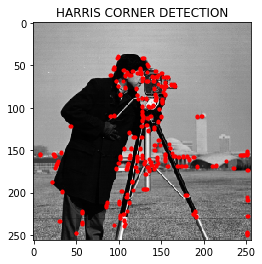

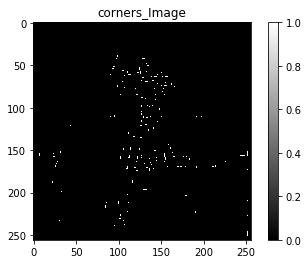

In [6]:
"""
Corner detection

Input: A, B, C matrix
Output: image with corner points

http://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf
http://aishack.in/tutorials/harris-corner-detector/
"""

def Harris_corner_detection(A, C, B):
    row, column = A.shape
    corners_Image = np.zeros((row, column))
    R = np.zeros((row, column))
    Rmax = 0

    for i in range(row):
        for j in range(column):
            H = np.array([[A[i, j], B[i, j]], [B[i, j], C[i, j]]])
            R[i, j] = np.linalg.det(H) - 0.04 * (np.power(np.trace(H), 2))
            if R[i, j] > Rmax:
                Rmax = R[i, j]
    
    for i in range(row - 1):
        for j in range(column - 1):
            # Choose those points where λmin is a local maximum as features
            if R[i, j] > 0.01 * Rmax and R[i, j] > R[i-1, j-1] and R[i, j] > R[i-1, j+1] and R[i, j] > R[i+1, j-1] and R[i, j] > R[i+1, j+1]:
                corners_Image[i, j] = 1
                
    y, x = np.where(corners_Image == 1)
    plt.plot(x, y, 'r.')
    plt.title("HARRIS CORNER DETECTION")
    plt.imshow(image_in, 'gray')
    plt.savefig('Harris_corner_detection.png')
    plt.show()
    
    return(corners_Image)

corners_Image = Harris_corner_detection(A, C, B)
print_image(corners_Image, "corners_Image")